# Numpy 1D-DFT
1. reference: http://dcwww.camd.dtu.dk/~askhl/files/python-dft-exercises.pdf
2. Goal: Write our own `Kohn-Sham(KS) DFT` code
    1. Target: a harmonic oscillator including:
        - electronic kinetic energy
        - electrostatic repulsion between electrons 
        - the local density approximation for electronic interactions, ignoring correlation
    1. `Hamitonian` for `Harmonic oscillator`:
        $$\begin{cases}
        \^{H} = -\frac{1}{2}\frac{d^2}{dx^2} + v(x) \\
        v(x) = v_{Ha}(x) + v_{LDA}(x) + x^2
        \end{cases}$$
3. What we have to do?
    1. Represent the `Hamiltonian for harmonic oscillator`
    2. Calculate the `KS wavefunction`, `the density`

In [333]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Free non-interacting electrons (For `Harmonic oscillator`)

<font color="red">

Note
----
1. Only contains `electronic kinetic energy`

</font >

In [334]:
num_grids = 201
xs_lst = np.linspace(-5, 5, num_grids)
ys_lst = np.sin(xs_lst)

## 1.1. First/Second order differentiation (FDM)

1. Approximately:
   $$ f^{'}(x) = \frac{f(x+dx) - f(x)}{dx} $$

2. Then: 
   $$ f^{''}(x) = \frac{f(x+dx) - 2f(x) + f(x-dx)}{dx^2} $$

3. We should represent `the second order differentiation` with `matrix`

In [336]:
# 1. calculate the space between grids
dx = np.diff(xs_lst).mean()

# 2. 将 Harmonic oscillator 的二阶导以矩阵形式表示
dia = -2 * np.ones(num_grids)
offdia = np.ones(num_grids - 1)
    # np.diag(offdia, 1)  : 首列加一列 (全为0)
    # np.diag(offdia, -1) : 首行加一行 (全为0)
derivative_x_2 = np.mat( np.diag(dia, 0) + np.diag(offdia, -1) + np.diag(offdia, 1) )
derivative_x_2 = derivative_x_2 / np.power(dx, 2)
operator_kinetic = - 1 / 2 * derivative_x_2

# 3. Avoid strage things at the edge of the grid
#d2grid[0, :] = 0
#d2grid[n_grid-1, :] = 0

print("The operator for kinetic energy of harmonic oscillator is represented by matrix:\n")
operator_kinetic

The operator for kinetic energy of harmonic oscillator is represented by matrix:



matrix([[ 400., -200.,    0., ...,    0.,    0.,    0.],
        [-200.,  400., -200., ...,    0.,    0.,    0.],
        [   0., -200.,  400., ...,    0.,    0.,    0.],
        ...,
        [   0.,    0.,    0., ...,  400., -200.,    0.],
        [   0.,    0.,    0., ..., -200.,  400., -200.],
        [   0.,    0.,    0., ...,    0., -200.,  400.]])

In [367]:
# eig_vals_lst: 本征值，按照升序排列，含重复
# eig_vecs_lst: 本征向量，eig_vecs_lst[i] 对应于 eig_vals_lst[i]
eig_vals_none_lst, eig_vecs_non_lst = np.linalg.eigh(operator_kinetic)

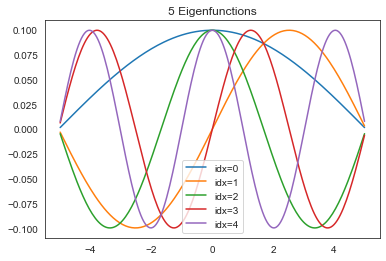

In [368]:
for idx in range(5):
    plt.plot(xs_lst, eig_vecs_non_lst[:, idx],
            label="idx={0}".format(idx))

plt.title('%d Eigenfunctions'%(5))
plt.legend()

## 2.1. Harmonic oscillator (`Adding potential energy`)
- Including the external potential $v_{external}=x^2$
$$ \^{H} = \^{T} = -\frac{1}{2}\frac{d^2}{dx^2} + x^2 $$

In [369]:
potentials_lst = np.power(xs_lst, 2)
potentials_matrix = np.diag(potentials_lst, 0)

In [370]:
H = operator_kinetic + potentials_matrix

eig_vals_harm_lst, eig_vecs_harm_lst = np.linalg.eigh(H)

### 2.1.1. Plot up the `eigenvalues`

Text(0.5, 0, 'index $n$')

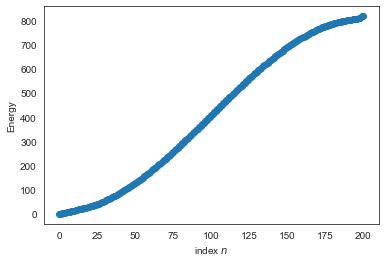

In [371]:
f, ax = plt.subplots()
ax.plot(eig_vals_harm_lst, 'o')
ax.set_ylabel('Energy')
ax.set_xlabel('index $n$')

### 2.1.2. plot some `eigenfunctions`

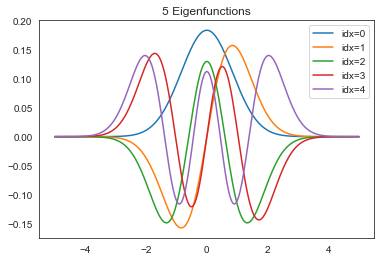

In [372]:
for idx in range(5):
    plt.plot(xs_lst, eig_vecs_harm_lst[:, idx],
            label="idx={0}".format(idx))

plt.title('%d Eigenfunctions'%(5))
plt.legend()

## 2.2. Well potential
- Hamiltonian:
$$ \^{H} = -\frac{1}{2}\frac{d^2}{dx^2} + V_{well}(x) $$

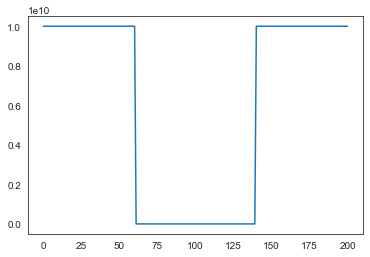

In [373]:
potentials_well_lst = np.full_like(xs_lst, 1e10)
potentials_well_lst[np.logical_and(xs_lst>-2, xs_lst<2)] = 0
plt.plot(potentials_well_lst)

In [374]:
eig_vals_well_lst, eig_vecs_well_lst = np.linalg.eigh(operator_kinetic + np.diag(potentials_well_lst))

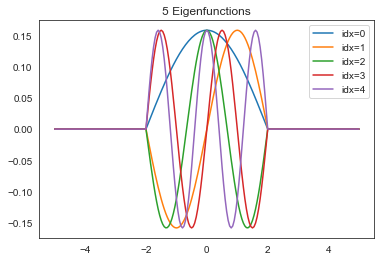

In [375]:
for idx in range(5):
    plt.plot(xs_lst, eig_vecs_well_lst[:, idx],
            label="idx={0}".format(idx))

plt.title('%d Eigenfunctions'%(5))
plt.legend()

# 3. Density
1. We will want to include:
    - `Coulomb` interaction
    - `Hatree` interaction
    - `LDA exchange`
    - Both of which are `density functionals` (密度的泛函)
2. So we need to calculate the electron density
3. Each state should be normalized:
    $$ \int{|\psi|^2dx} = 1 $$
4. Let $f_n$ be occupation numbers, the density $n(x)$ can be written as follows:
    $$ n(x) = \sum_{n}{f_n|\psi(x)|^2} $$

<font color="red">

Note
----
1. Each state fits up to two electrons: 
    - one with `spin up`
    - one with `spin down`.
2. In DFT, we calculate the `ground state`.（`电子填充由能量低到高进行`）
3. 注意行、向量的转换/转置

</font>

In [392]:
### Part I. 积分
def get_integral(xs_lst, ys_lst, axis=0):
    dx = np.diff(xs_lst).mean()
    return np.sum(ys_lst * dx, axis=axis)

print(get_integral(
            xs_lst=xs_lst,
            ys_lst=np.power(eig_vecs_non_lst, 2),
            axis=0
))

[[0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
  0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
  0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
  0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
  0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
  0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
  0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
  0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
  0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
  0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
  0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
  0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
  0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
  0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.

In [395]:
# 计算 density
def get_density(num_electrons, xs_lst, eig_vecs_lst):
    # 1. normalization
    I = get_integral(xs_lst=xs_lst,
                    ys_lst=np.power(eig_vecs_lst, 2),
                    axis=0)

    normed_eig_vecs_lst = eig_vecs_lst / np.sqrt(I)
    print(I.shape)
    print(eig_vecs_lst.shape)
    print(normed_eig_vecs_lst.shape)


    # 2. occupation number
    nums_electrons_lst = [2 for _ in range(num_electrons // 2)] 
    if (num_electrons % 2):
        nums_electrons_lst.append(1)
    
    # 3. calculate density
    densitys_lst = np.zeros_like(eig_vecs_lst[:, 0])    # 列向量
    for ne, psi in zip(nums_electrons_lst, normed_eig_vecs_lst.T):  # 
        densitys_lst += ne * np.power(psi.T, 2)

    return densitys_lst

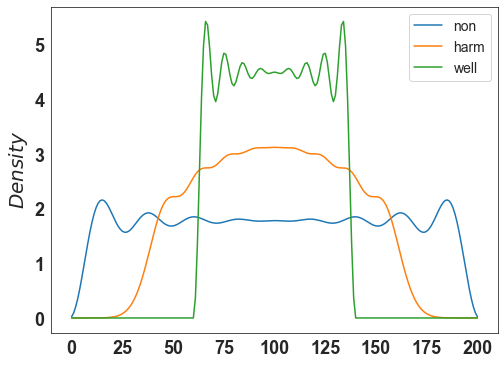

In [413]:
num_electrons = 17
plt.figure(figsize=(8, 6))
plt.plot(get_density(num_electrons,
                     xs_lst,
                     eig_vecs_non_lst), label="non")
plt.plot( get_density(num_electrons,
                     xs_lst,
                     eig_vecs_harm_lst), label="harm")
plt.plot(get_density(num_electrons,
                     xs_lst,
                     eig_vecs_well_lst), label="well")
## 3.1. retouch xlabel/ylabel

plt.ylabel("$Density$",
            fontsize="20",
            fontweight="bold")

## 3.2. retouch xticks/yticks
plt.xticks(fontsize="18",
            fontweight="bold")
plt.yticks(fontsize="18",
            fontweight="bold")

## 3.3. retouch legend
plt.rcParams.update({"font.size": 14})
plt.legend(loc=1)

plt.show()

# 4. Exchange Energy